In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
plt.style.use('ggplot')

### Import Emissions Data

In [20]:
# Import Emissions Data
emissions_df = pd.read_csv('Data_Files/fossil-fuel-co2-emissions-by-nation_csv.csv')
emissions_df.head()

,Year,Country,Total,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels (Not in Total)
0,1751,UNITED KINGDOM,2552,2552,0,0,0,0,0.0,0
1,1752,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
2,1753,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
3,1754,UNITED KINGDOM,2554,2554,0,0,0,0,0.0,0
4,1755,UNITED KINGDOM,2555,2555,0,0,0,0,0.0,0


In [21]:
# Drop unnecessary columns and rename remaining columns
emissions_df.drop(labels = ['Solid Fuel', 'Liquid Fuel', 'Gas Fuel', 'Cement', 'Gas Flaring',
                            'Per Capita', 'Bunker fuels (Not in Total)'], axis = 1, inplace = True)
emissions_df.columns = ['Year', 'Country', 'Fossil_Fuel_CO2_Emissions']
emissions_df.head()

,Year,Country,Fossil_Fuel_CO2_Emissions
0,1751,UNITED KINGDOM,2552
1,1752,UNITED KINGDOM,2553
2,1753,UNITED KINGDOM,2553
3,1754,UNITED KINGDOM,2554
4,1755,UNITED KINGDOM,2555


In [22]:
def select_countries(country):
    selected_countries = ['UNITED STATES OF AMERICA', 'SPAIN', 'AUSTRALIA', 'SOUTH AFRICA', 'CHINA (MAINLAND)', 'BRAZIL'] 
    if (country in selected_countries): 
        return True
    else: 
        return False

In [23]:
# Select countries and create dictionary of country/dataframe
chosen_countries = filter(select_countries, list(emissions_df.Country.unique()))

country_df_names = []
for country in chosen_countries:
    df_name = f"{country}_df"
    country_df_names.append(df_name)

country_df_dict = {}
for df in country_df_names:
    country_df_dict[df] = emissions_df[emissions_df.Country == df[:-3]]

In [24]:
# Convert each country dataframe into proper time series layout
for key in country_df_dict.keys():
    country_df_dict[key].Year = pd.to_datetime(country_df_dict[key].Year, format = '%Y')
    country_df_dict[key].drop('Country', axis = 1, inplace = True)
    country_df_dict[key].set_index('Year', inplace = True)

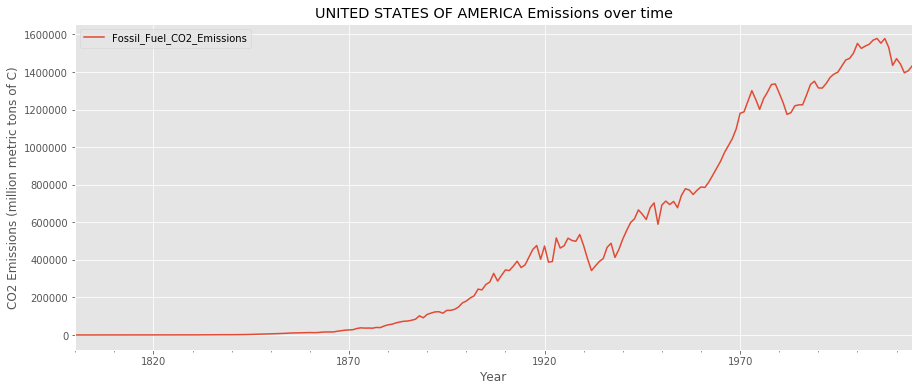

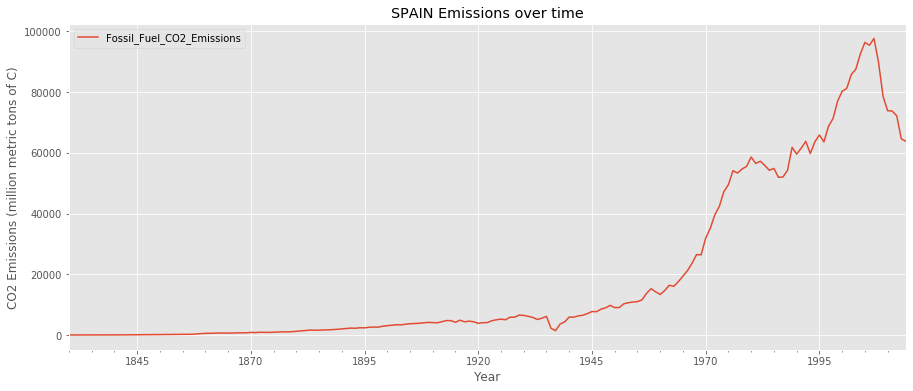

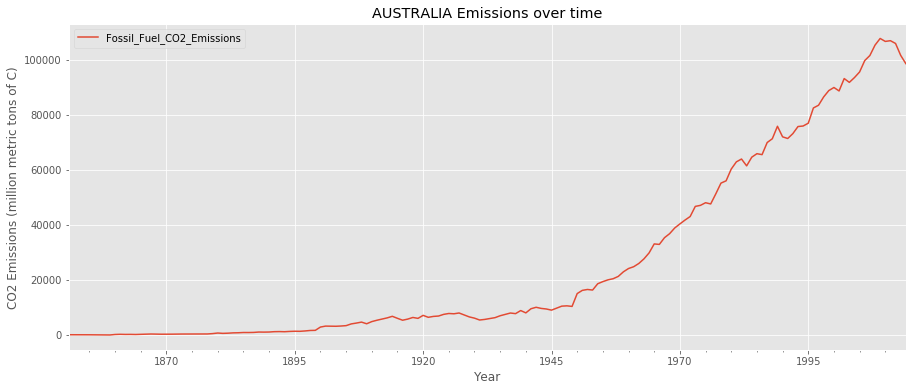

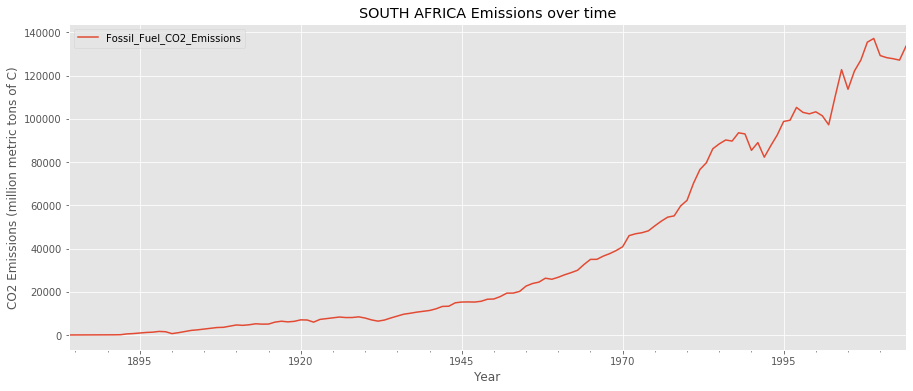

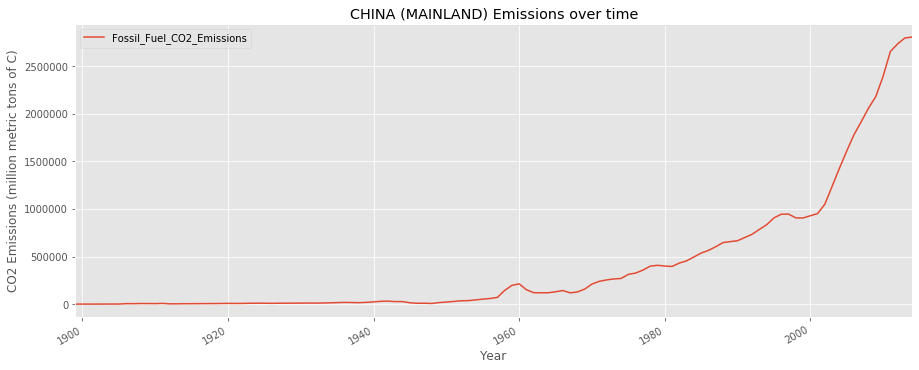

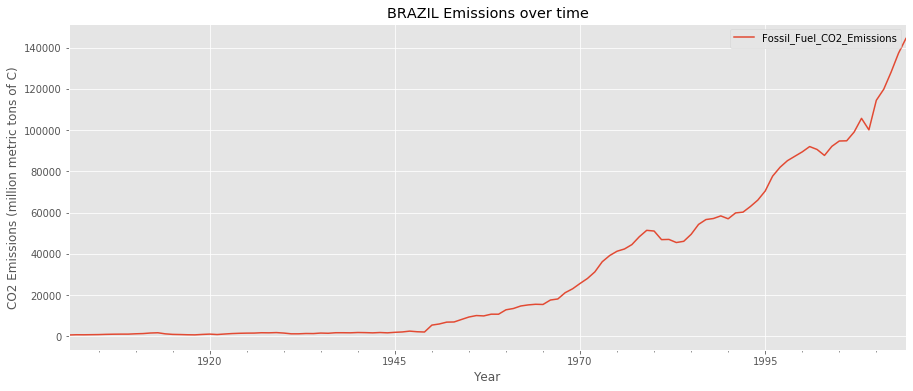

In [25]:
# Visualize Time Series by Country
for key in country_df_dict.keys(): 
    country_df_dict[key].plot(figsize=(15,6))
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions (million metric tons of C)')
    plt.title(f'{key[:-3]} Emissions over time')
    plt.show()

In [30]:
# Drop years prior to 1902 (China has gaps prior to this year)
for key in country_df_dict.keys():
    country_df_dict[key] = country_df_dict[key].loc[(country_df_dict[key].index >= pd.to_datetime(1902, format = '%Y'))]

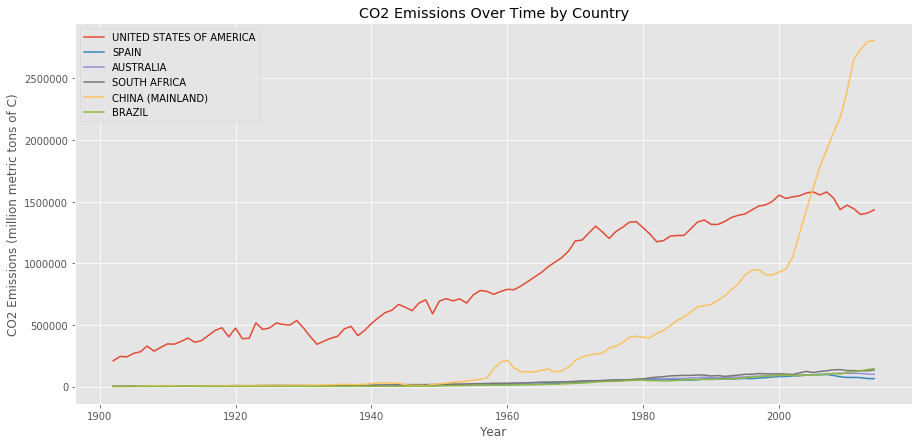

In [38]:
# Visualize All Time Series Together
fig, ax = plt.subplots(figsize = (15,7))

for key in country_df_dict.keys(): 
    ax.plot(country_df_dict[key], label = key[:-3])
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons of C)')
plt.title('CO2 Emissions Over Time by Country')
plt.legend(loc = 'best')
plt.show()


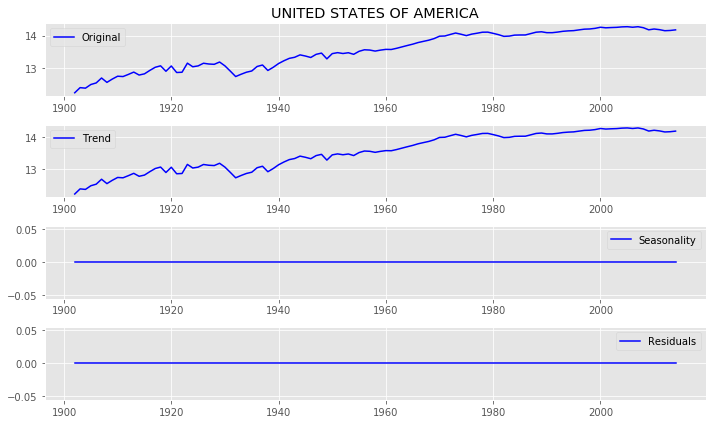

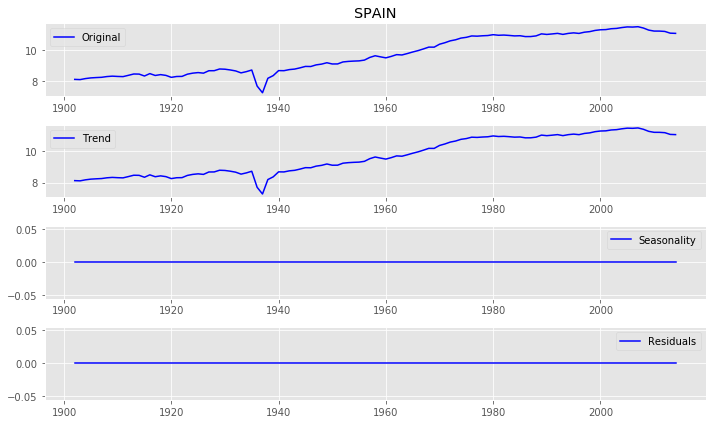

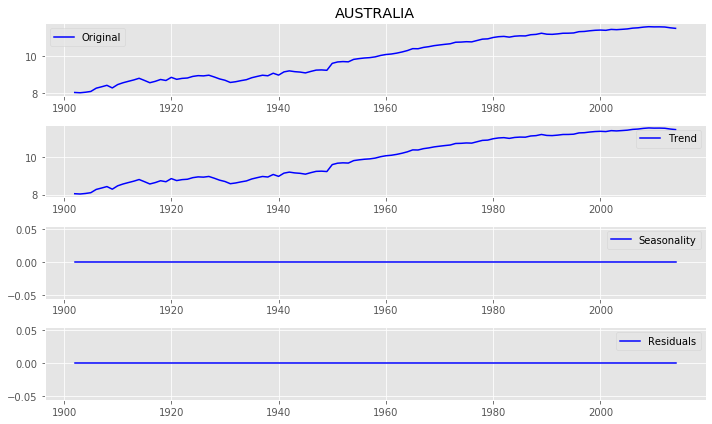

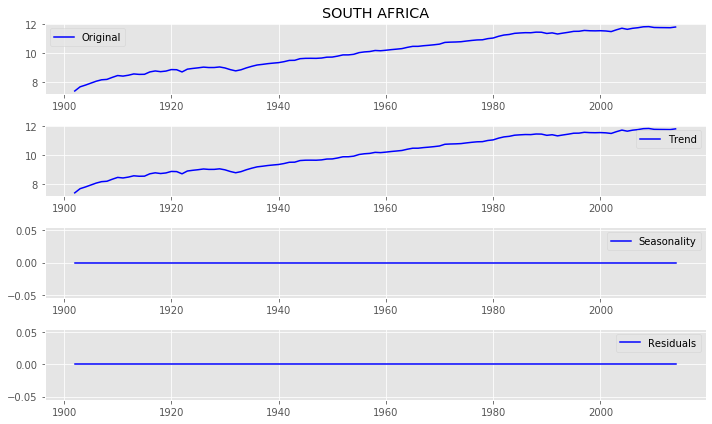

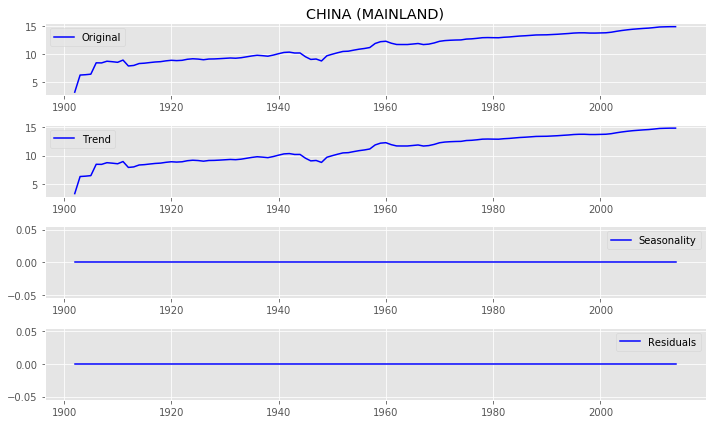

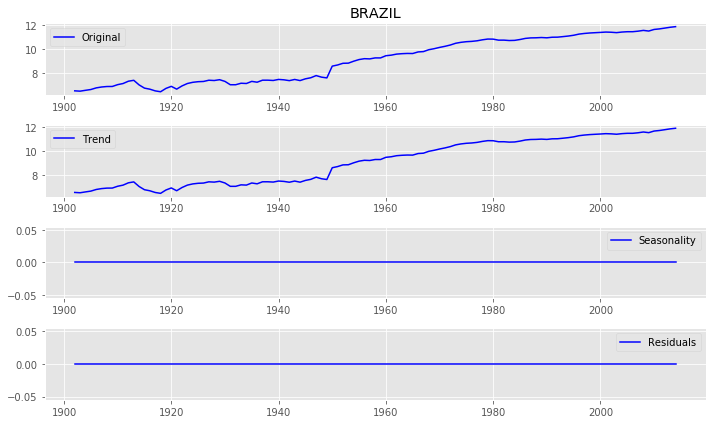

In [137]:
# Decompose Country TSs
from statsmodels.tsa.seasonal import seasonal_decompose
for key in country_df_dict.keys():
    ts = country_df_dict[key]
    decomposition = seasonal_decompose(np.log(ts))
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(10,6))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color="blue")
    plt.legend(loc='best')
    plt.title(f'{key[:-3]}')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout()

In [41]:
# Perform 1st order differencing on each time series
diff_country_df_dict = {}
for key in country_df_dict.keys():
    diff_country_df_dict[key] = country_df_dict[key].diff(periods = 1).dropna()

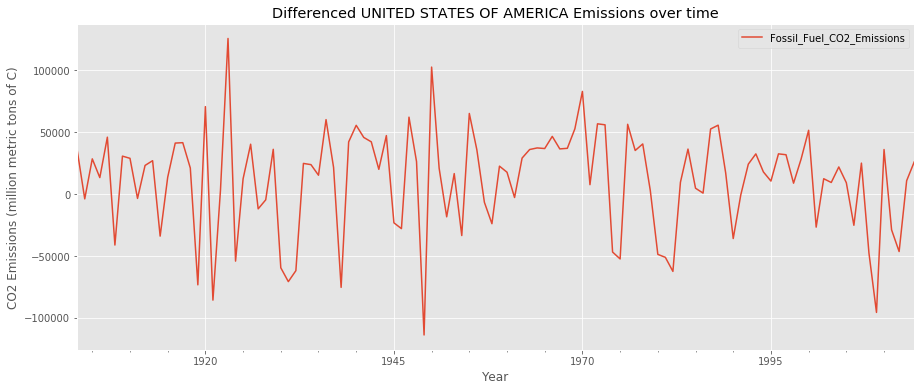

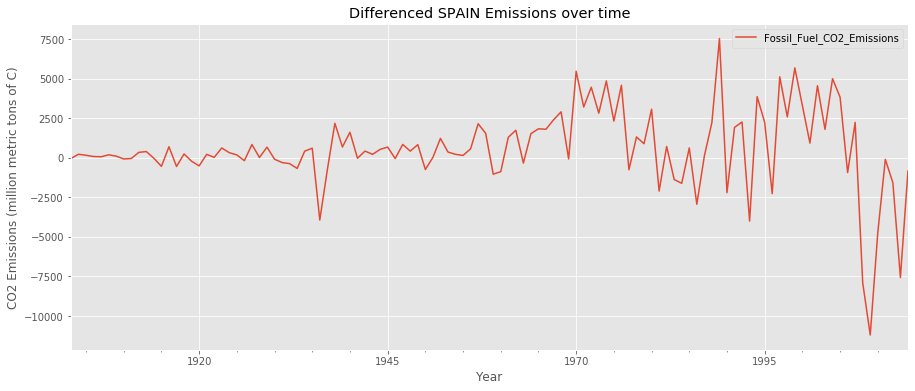

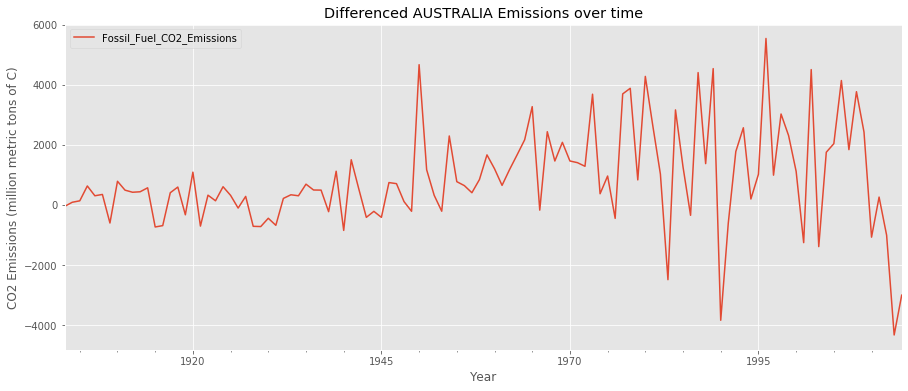

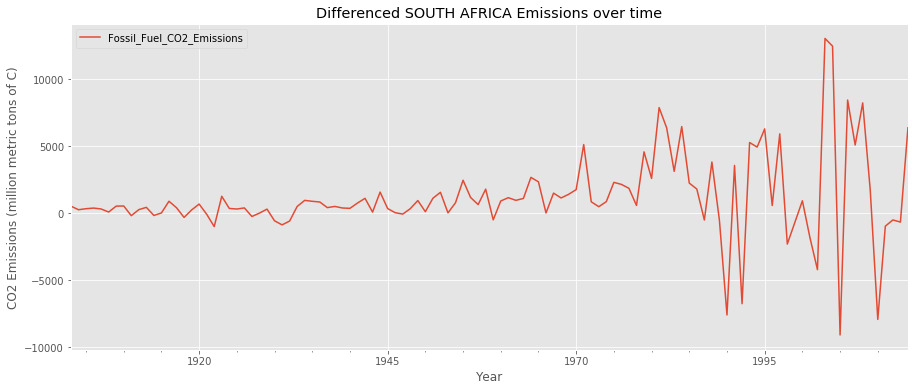

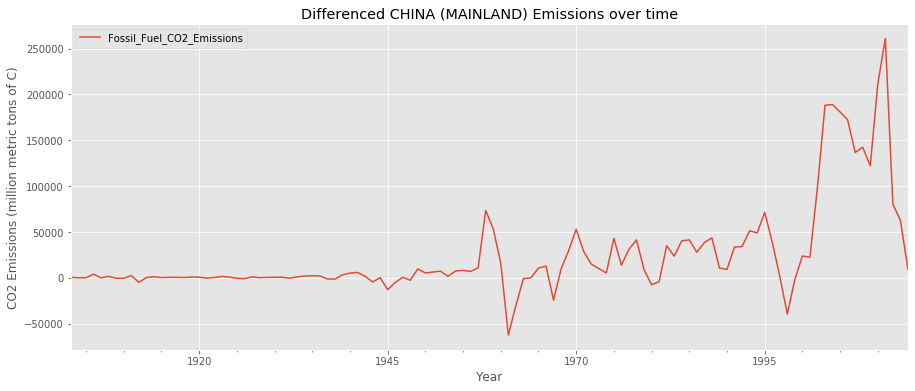

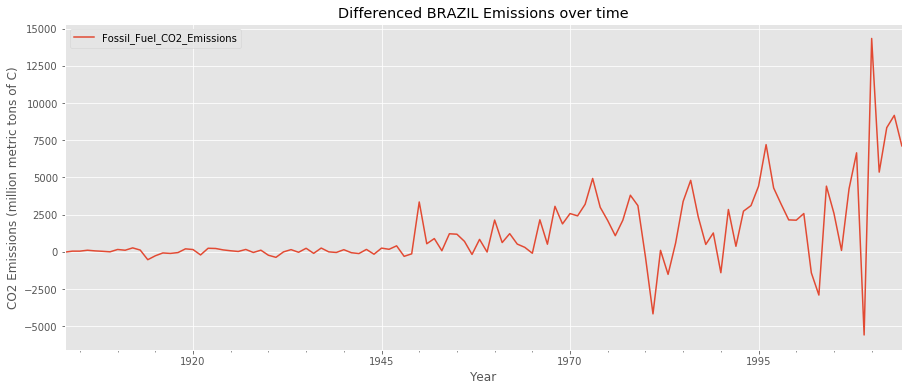

In [43]:
# Visualize Differenced Time Series by Country
for key in diff_country_df_dict.keys(): 
    diff_country_df_dict[key].plot(figsize=(15,6))
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions (million metric tons of C)')
    plt.title(f'Differenced {key[:-3]} Emissions over time')
    plt.show()

In [44]:
# Dickey-Fuller Tests on 1st Order Differenced TSs
dftest_pvalue_dict = {}
for key in diff_country_df_dict.keys():
    dftest = adfuller(diff_country_df_dict[key].Fossil_Fuel_CO2_Emissions)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
    dftest_pvalue_dict[key] = dftest[1]
dftest_pvalue_dict
print((np.array(list(dftest_pvalue_dict.values())) < .05).sum())
dftest_pvalue_dict

4


{'UNITED STATES OF AMERICA_df': 1.2665484553288515e-05,
 'SPAIN_df': 0.01135832901522947,
 'AUSTRALIA_df': 0.4647913523000541,
 'SOUTH AFRICA_df': 1.818594942518012e-17,
 'CHINA (MAINLAND)_df': 0.027794195298366096,
 'BRAZIL_df': 0.6368545482018173}

In [45]:
# Perform 2nd order differencing on each time series
diff2_country_df_dict = {}
for key in diff_country_df_dict.keys():
    diff2_country_df_dict[key] = diff_country_df_dict[key].diff(periods = 1).dropna()

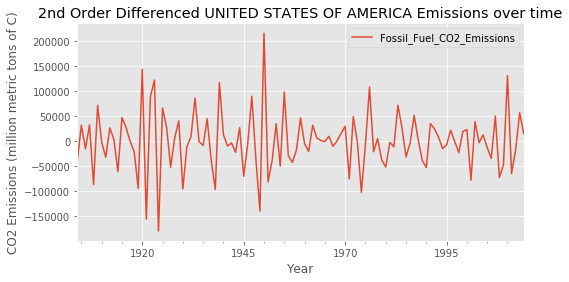

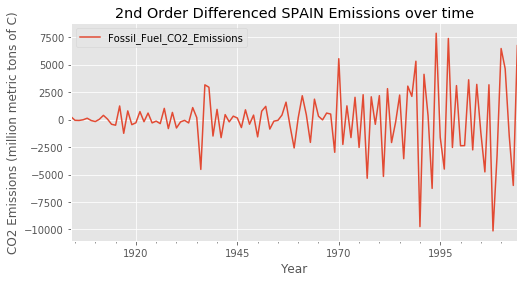

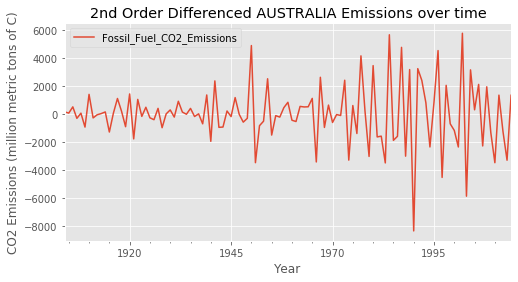

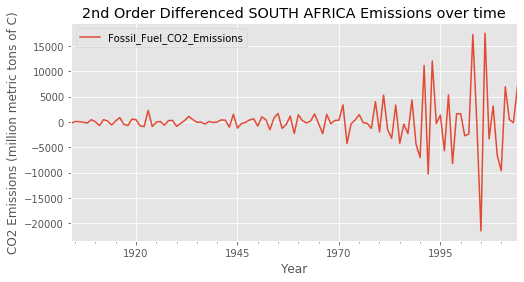

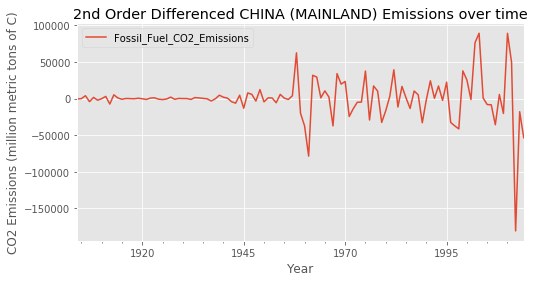

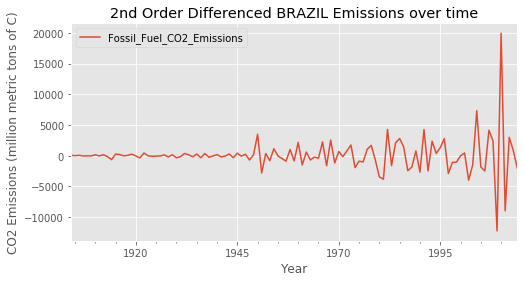

In [138]:
# Visualize 2nd Order Differenced Time Series by Country
for key in diff2_country_df_dict.keys(): 
    diff2_country_df_dict[key].plot(figsize=(8,4))
    plt.xlabel('Year')
    plt.ylabel('CO2 Emissions (million metric tons of C)')
    plt.title(f'2nd Order Differenced {key[:-3]} Emissions over time')
    plt.show()

In [47]:
# Dickey-Fuller Tests on 2nd Order Differenced TSs
dftest_pvalue_dict = {}
for key in diff2_country_df_dict.keys():
    dftest = adfuller(diff2_country_df_dict[key].Fossil_Fuel_CO2_Emissions)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
    dftest_pvalue_dict[key] = dftest[1]
dftest_pvalue_dict
print((np.array(list(dftest_pvalue_dict.values())) < .05).sum())
dftest_pvalue_dict

6


{'UNITED STATES OF AMERICA_df': 7.82041230964063e-12,
 'SPAIN_df': 4.2253241088536187e-23,
 'AUSTRALIA_df': 3.921382949841658e-09,
 'SOUTH AFRICA_df': 0.00014663032960343103,
 'CHINA (MAINLAND)_df': 2.4816636271367432e-05,
 'BRAZIL_df': 7.766630283148366e-10}

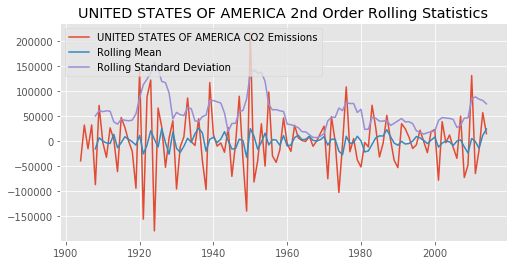

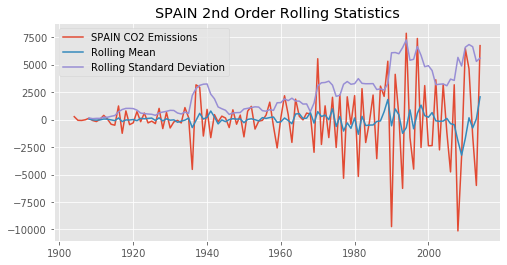

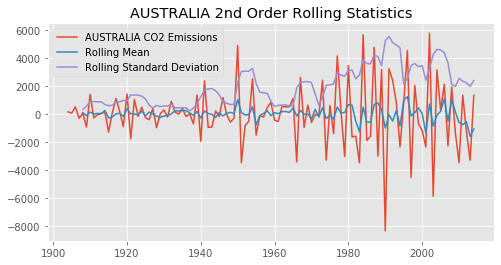

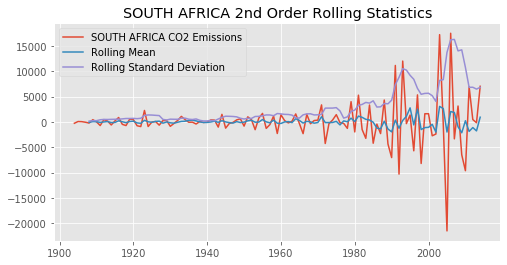

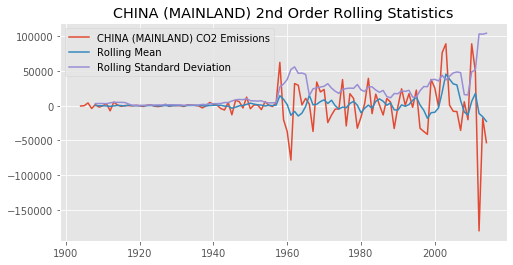

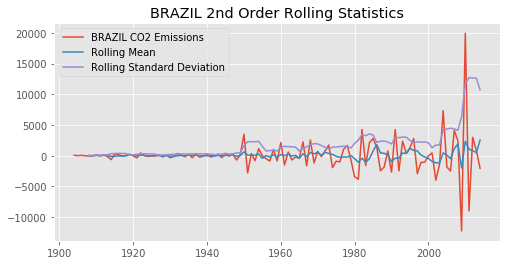

In [139]:
# Assess Trends with Rolling Statistics
for key in diff2_country_df_dict.keys():
    ts = diff2_country_df_dict[key]
    rolmean = ts.rolling(window = 5, center = False).mean()
    rolstd = ts.rolling(window = 5, center = False).std()
    fig, ax = plt.subplots(figsize = (8,4))
    ax.plot(ts, label = f'{key[:-3]} CO2 Emissions')
    ax.plot(rolmean, label = 'Rolling Mean')
    ax.plot(rolstd, label = 'Rolling Standard Deviation')
    plt.legend(loc = 'upper left')
    plt.title(f'{key[:-3]} 2nd Order Rolling Statistics')
    plt.show()

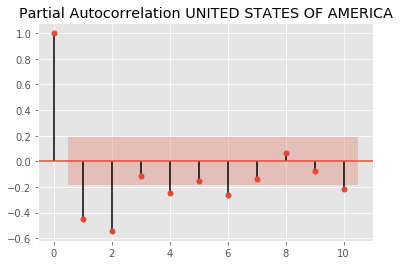

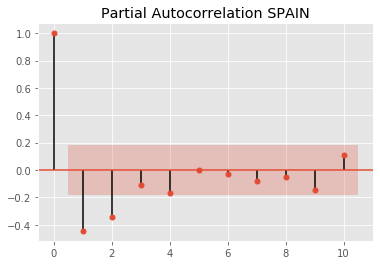

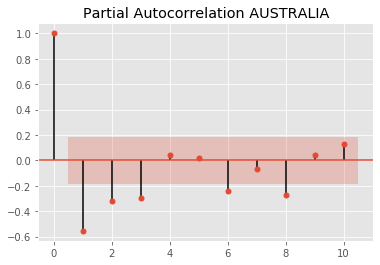

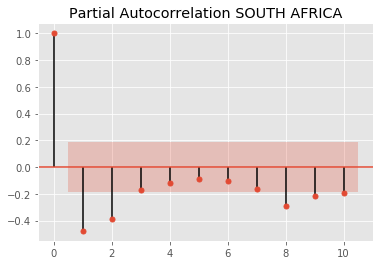

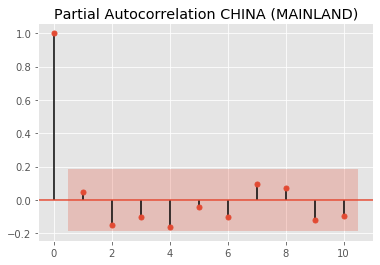

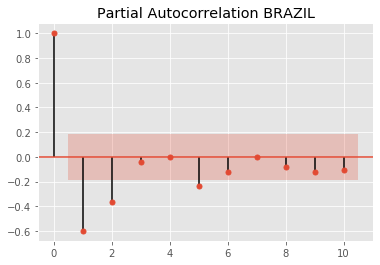

In [146]:
# Plot Partial Autocorrelation Plots for each country on 2nd order difference time series (Determine AR)
from statsmodels.graphics.tsaplots import plot_pacf

for key in diff2_country_df_dict.keys():
    plot_pacf(diff2_country_df_dict[key], lags = 10)
    plt.title(f'Partial Autocorrelation {key[:-3]}')
    plt.show()

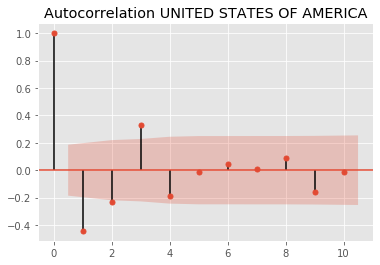

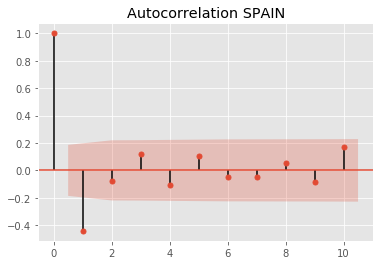

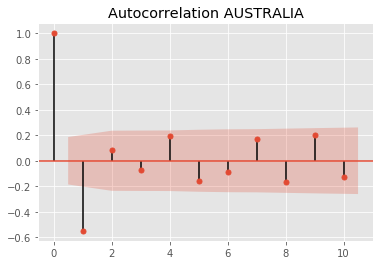

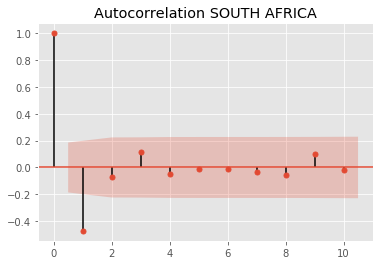

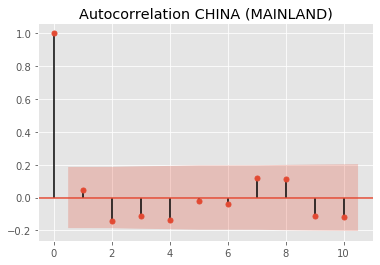

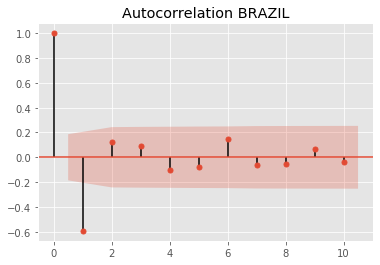

In [51]:
# Plot Autocorrelation Plots for each country on 2nd order difference time series (Determine MA)
from statsmodels.graphics.tsaplots import plot_acf

for key in diff2_country_df_dict.keys():
    plot_acf(diff2_country_df_dict[key], lags = 10)
    plt.title(f'Autocorrelation {key[:-3]}')

In [54]:
# Create optimal parameters dictionary to be used in ARIMA model (based on ACF and PACF results) -> (p,d,q)
optimal_params = {}
for key in diff2_country_df_dict.keys():
    optimal_params[key] = ()

optimal_params['UNITED STATES OF AMERICA_df'] = (2, 2, 1)
optimal_params['SPAIN_df'] = (2, 2, 1)
optimal_params['AUSTRALIA_df'] = (3, 2, 1)
optimal_params['SOUTH AFRICA_df'] = (2, 2, 1)
optimal_params['CHINA (MAINLAND)_df'] = (0, 2, 0)
optimal_params['BRAZIL_df'] = (2, 2, 1)

### Fitting Models

UNITED STATES OF AMERICA Summary                                Statespace Model Results                              
Dep. Variable:     Fossil_Fuel_CO2_Emissions   No. Observations:                  113
Model:                      SARIMAX(2, 2, 1)   Log Likelihood               -1320.660
Date:                       Mon, 06 Jan 2020   AIC                           2649.320
Time:                               18:01:15   BIC                           2660.085
Sample:                           01-01-1902   HQIC                          2653.685
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2500      0.124     -2.023      0.043      -0.492      -0.008
ar.L2         -0.3070      0.118     -2.59

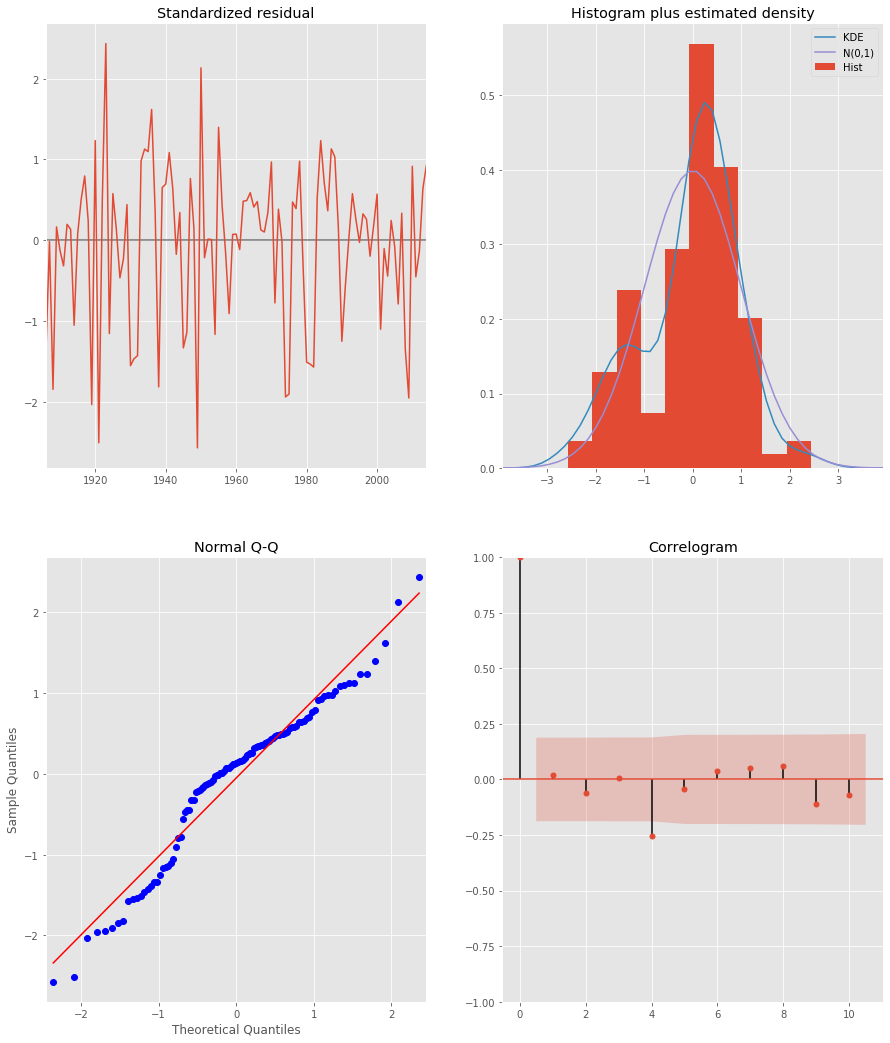



SPAIN Summary                                Statespace Model Results                              
Dep. Variable:     Fossil_Fuel_CO2_Emissions   No. Observations:                  113
Model:                      SARIMAX(2, 2, 1)   Log Likelihood               -1003.612
Date:                       Mon, 06 Jan 2020   AIC                           2015.224
Time:                               18:01:15   BIC                           2025.989
Sample:                           01-01-1902   HQIC                          2019.590
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0247      0.145     -0.171      0.864      -0.308       0.259
ar.L2         -0.0436      0.112     -0.391      0.696     

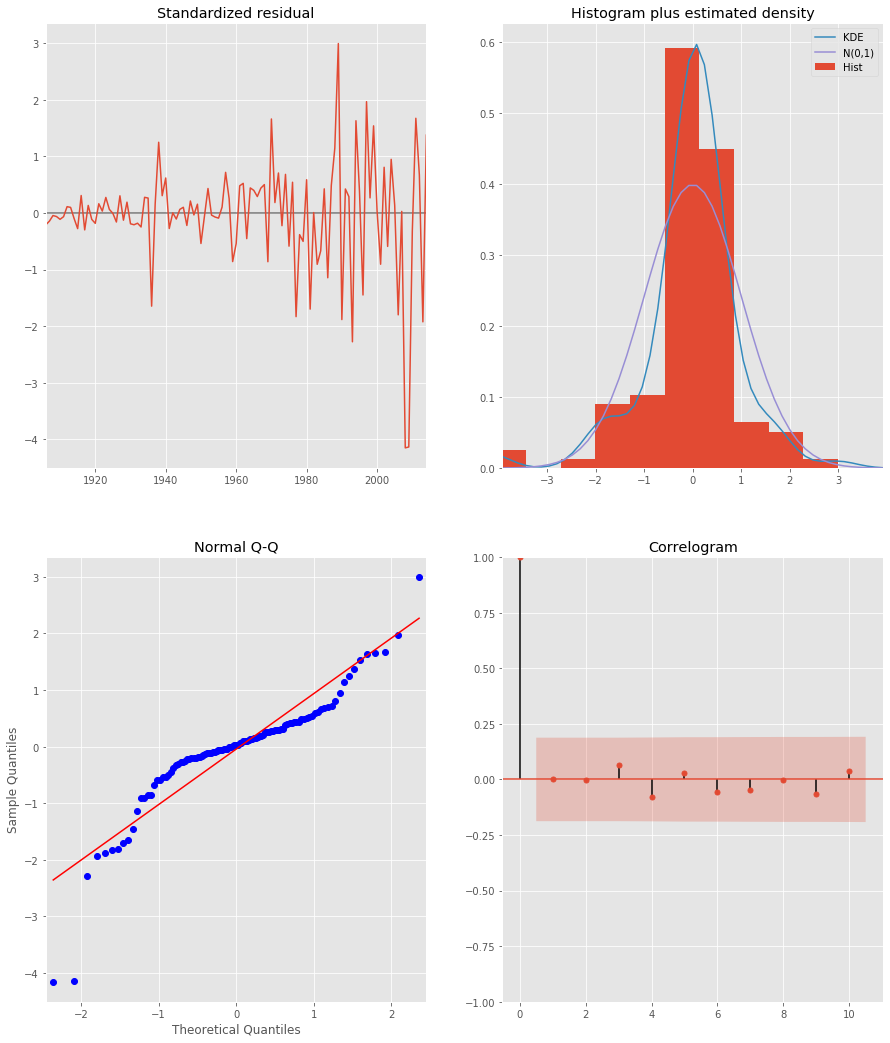



AUSTRALIA Summary                                Statespace Model Results                              
Dep. Variable:     Fossil_Fuel_CO2_Emissions   No. Observations:                  113
Model:                      SARIMAX(3, 2, 1)   Log Likelihood                -953.433
Date:                       Mon, 06 Jan 2020   AIC                           1916.867
Time:                               18:01:16   BIC                           1930.277
Sample:                           01-01-1902   HQIC                          1922.304
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0122      0.102      0.120      0.905      -0.188       0.213
ar.L2          0.0865      0.138      0.625      0.532 

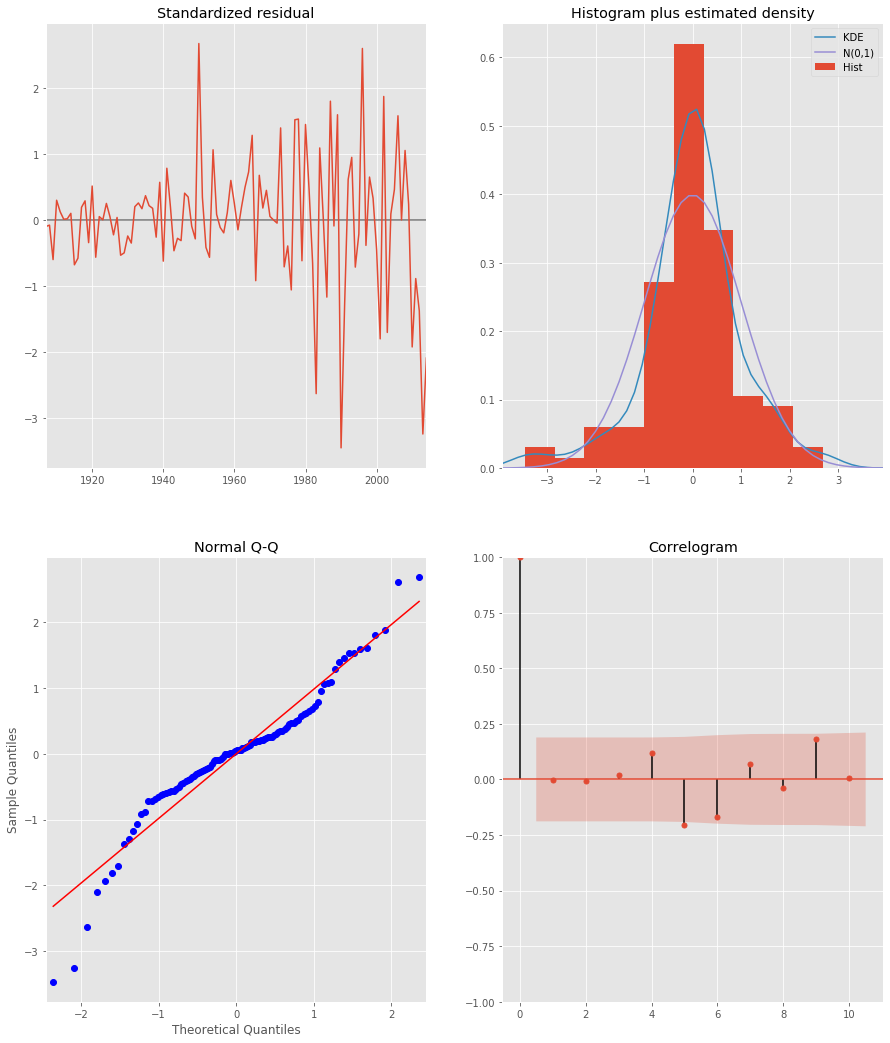



SOUTH AFRICA Summary                                Statespace Model Results                              
Dep. Variable:     Fossil_Fuel_CO2_Emissions   No. Observations:                  113
Model:                      SARIMAX(2, 2, 1)   Log Likelihood               -1034.816
Date:                       Mon, 06 Jan 2020   AIC                           2077.632
Time:                               18:01:17   BIC                           2088.397
Sample:                           01-01-1902   HQIC                          2081.997
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0147      0.062     -0.235      0.814      -0.137       0.108
ar.L2         -0.0484      0.066     -0.734      0.4

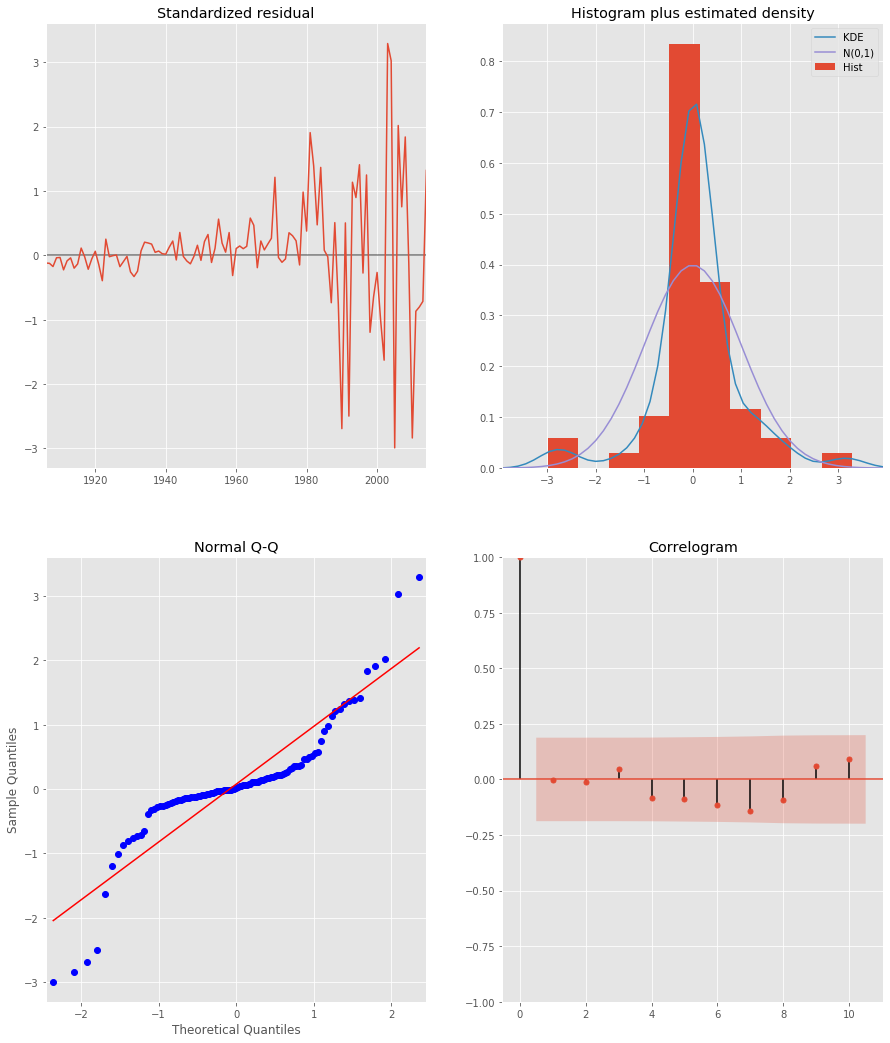



CHINA (MAINLAND) Summary                                Statespace Model Results                              
Dep. Variable:     Fossil_Fuel_CO2_Emissions   No. Observations:                  113
Model:                      SARIMAX(0, 2, 0)   Log Likelihood               -1288.334
Date:                       Mon, 06 Jan 2020   AIC                           2578.669
Time:                               18:01:18   BIC                           2581.369
Sample:                           01-01-1902   HQIC                          2579.764
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.486e+08    4.1e+07     20.721      0.000    7.68e+08    9.29e+08
Ljung-Box (Q):                       31.06   Jar

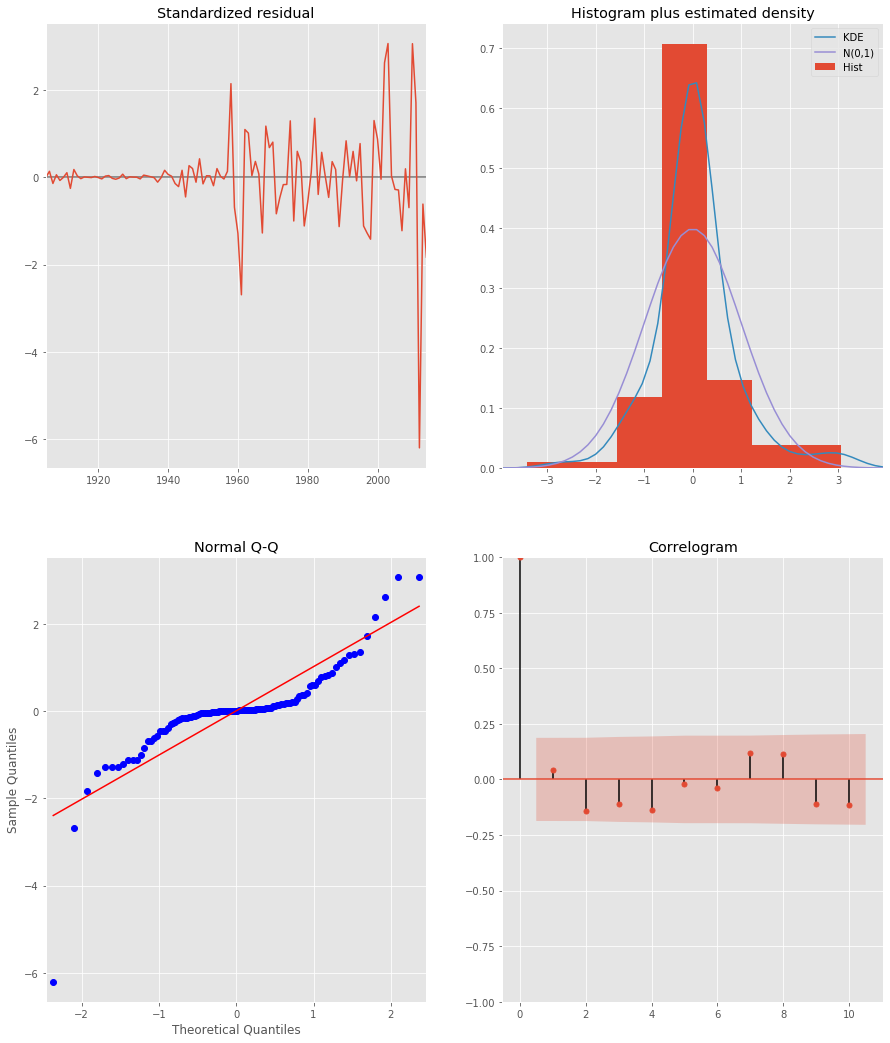



BRAZIL Summary                                Statespace Model Results                              
Dep. Variable:     Fossil_Fuel_CO2_Emissions   No. Observations:                  113
Model:                      SARIMAX(2, 2, 1)   Log Likelihood                -993.954
Date:                       Mon, 06 Jan 2020   AIC                           1995.908
Time:                               18:01:18   BIC                           2006.673
Sample:                           01-01-1902   HQIC                          2000.274
                                - 01-01-2014                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7356      0.297     -2.477      0.013      -1.318      -0.154
ar.L2         -0.3137      0.214     -1.463      0.144    

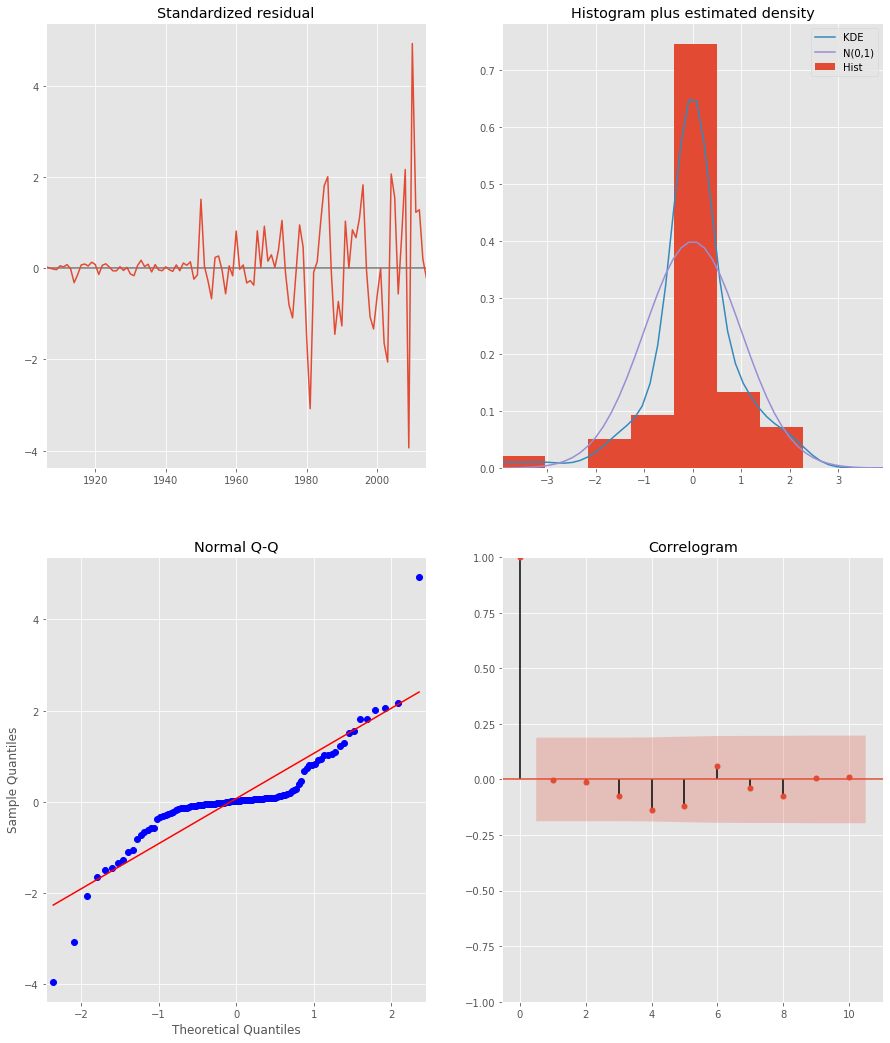

In [73]:
# Fit ARIMA Models and store results
results_dict = {}
for key in country_df_dict.keys():
    ts = country_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order=optimal_params[key],
                                            enforce_stationarity=False, enforce_invertibility=False)
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key[:-3]} Summary {results.summary()}')
    print()
    results.plot_diagnostics(figsize=(15, 18))
    plt.show()
    print()
    print()

### Model Validation

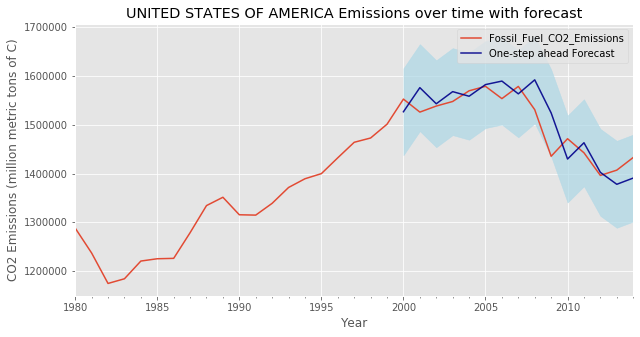

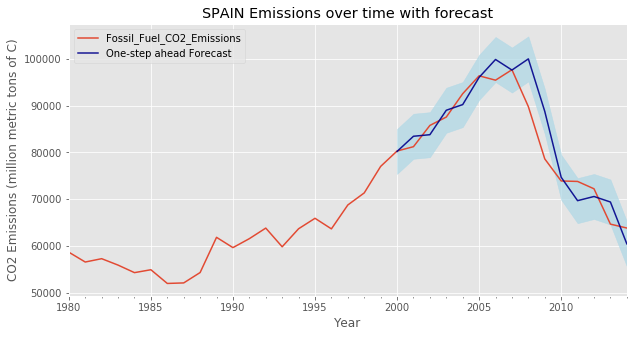

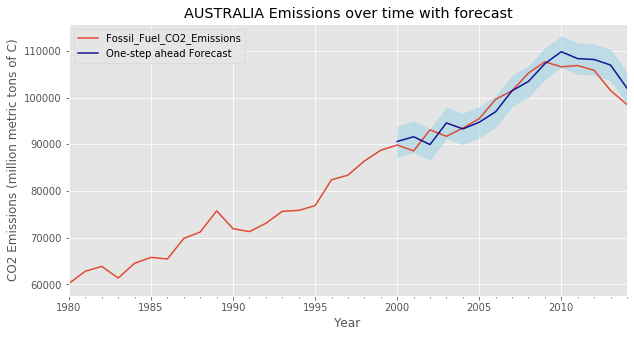

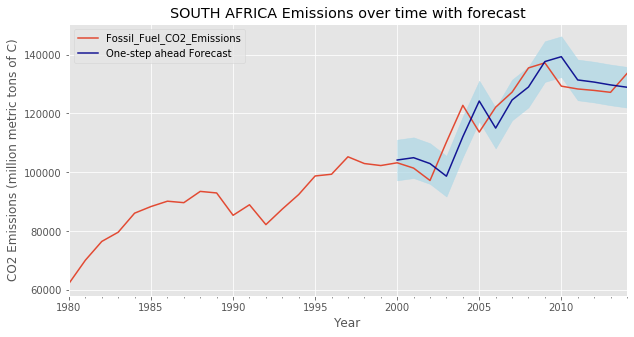

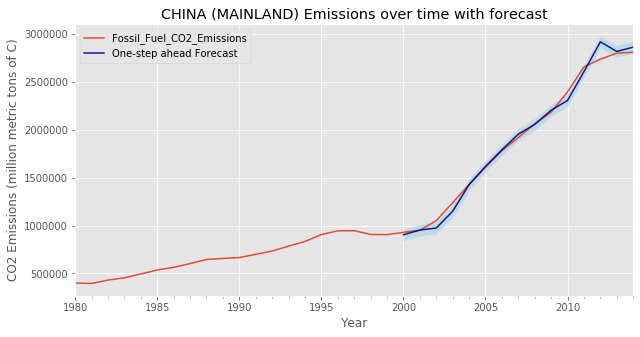

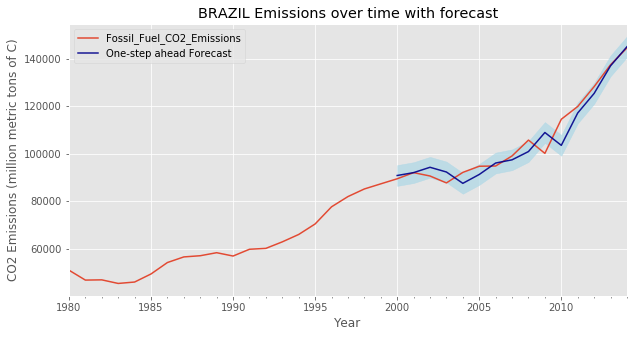

In [147]:
# Get predictions starting from 2000 and calculate confidence intervals.
for key in results_dict.keys():
    results = results_dict[key]
    predictions = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
    pred_conf = predictions.conf_int()
    
    #Plot observed values
    ax = country_df_dict[key]['1980':].plot(label='observed', figsize = (10,5))

    #Plot predicted values
    predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue')

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

    #Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2 Emissions (million metric tons of C)')
    plt.legend()
    plt.title(f'{key[:-3]} Emissions over time with forecast')
    plt.show()

### Model Predictions

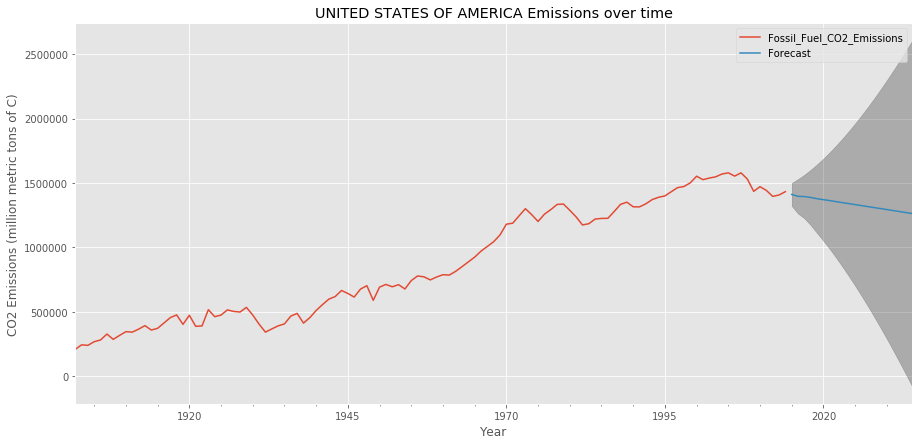

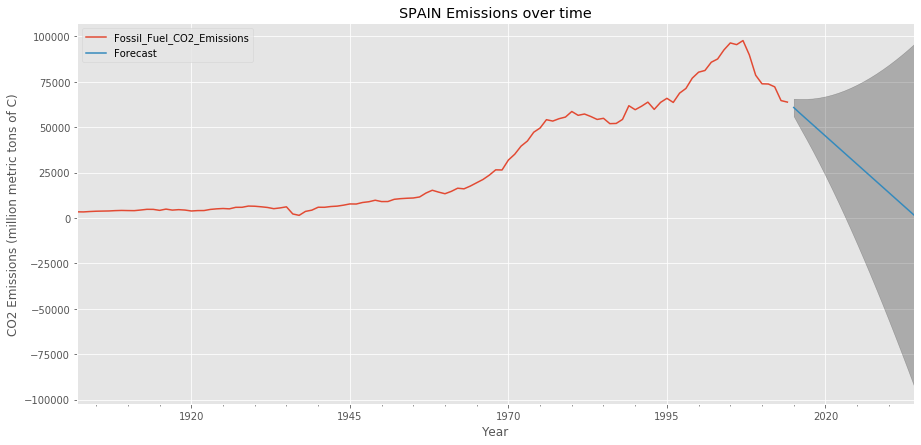

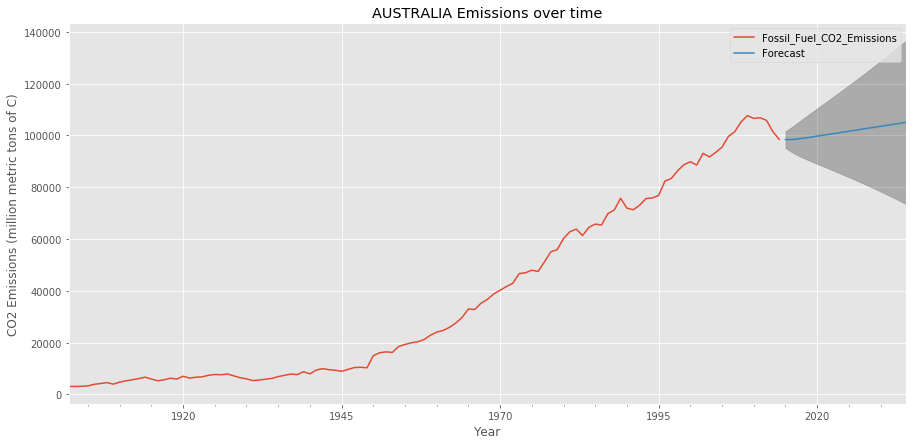

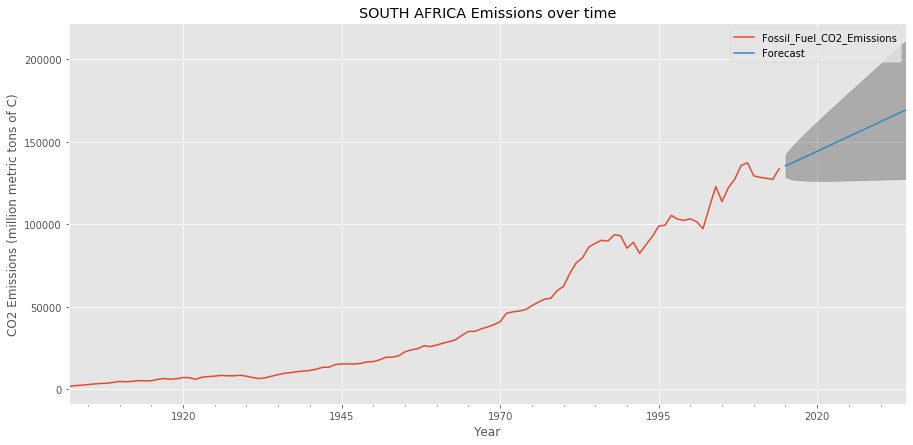

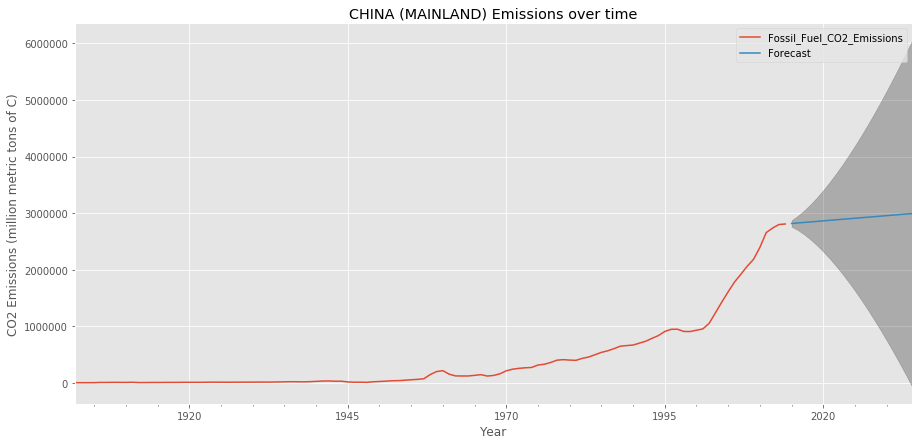

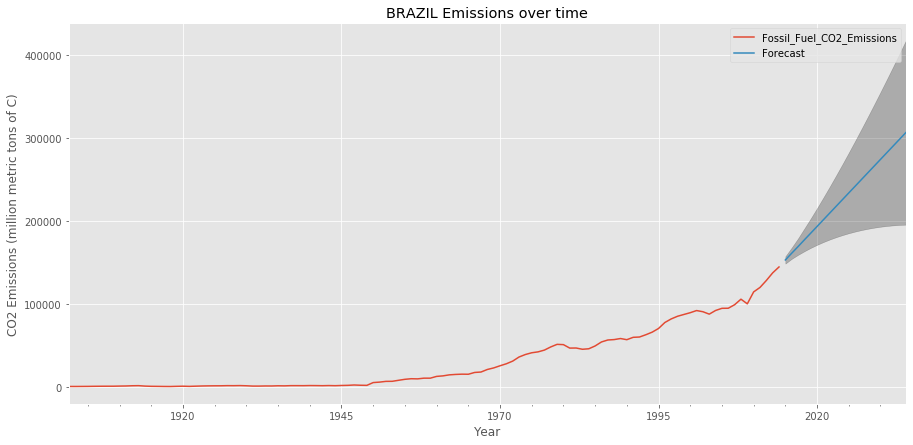

In [82]:
# Get forecast 20 steps ahead in future and confidence intervals
for key in results_dict.keys():
    results = results_dict[key]
    prediction = results.get_forecast(steps=20)
    pred_conf = prediction.conf_int()
    
    ax = country_df_dict[key].plot(label='observed', figsize=(15,7))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2 Emissions (million metric tons of C)')
    plt.title(f'{key[:-3]} Emissions over time')
    plt.legend()
    plt.show()

### Auto ARIMA

In [83]:
from pyramid.arima import auto_arima

/Users/bengeissel/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/bengeissel/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [89]:
# Auto Arima
auto_arima_results_dict = {}
for key in country_df_dict.keys():
    ts = country_df_dict[key]
    stepwise_model = auto_arima(ts, start_p=0, start_q=0,
                               max_p=3, max_q=3, m=1, seasonal=False, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    auto_arima_results_dict[key] = stepwise_model
    print(key[:-3])
    print(stepwise_model.aic())

Fit ARIMA: order=(0, 1, 0); AIC=2705.317, BIC=2710.754, Fit time=0.043 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2707.273, BIC=2715.429, Fit time=0.018 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2707.259, BIC=2715.414, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.117 seconds
UNITED STATES OF AMERICA
2705.316806723222
Fit ARIMA: order=(0, 1, 0); AIC=2077.551, BIC=2082.988, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2064.746, BIC=2072.901, Fit time=0.038 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2068.246, BIC=2076.402, Fit time=0.014 seconds
Fit ARIMA: order=(2, 1, 0); AIC=2063.412, BIC=2074.286, Fit time=0.088 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2063.050, BIC=2076.642, Fit time=0.159 seconds
Fit ARIMA: order=(3, 1, 2); AIC=2065.169, BIC=2084.199, Fit time=0.265 seconds
Fit ARIMA: order=(1, 1, 1); AIC=2061.196, BIC=2072.070, Fit time=0.099 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit

### Paris Climate Agreement Goals (40% cut from 1990 emissions by 2030)

In [120]:
# Calculate 40% Cut of 1990 Emissions by Country
paris_levels = {}
for key in country_df_dict.keys():
    ts = country_df_dict[key]
    emissions_1990 = ts[ts.index == pd.to_datetime(1990, format = '%Y')].get_value(pd.to_datetime(1990, format = '%Y'), 'Fossil_Fuel_CO2_Emissions')
    paris_levels[key] = emissions_1990*.6

In [121]:
paris_levels

{'UNITED STATES OF AMERICA_df': 789212.4,
 'SPAIN_df': 35767.2,
 'AUSTRALIA_df': 43147.799999999996,
 'SOUTH AFRICA_df': 51263.4,
 'CHINA (MAINLAND)_df': 399634.2,
 'BRAZIL_df': 34178.4}

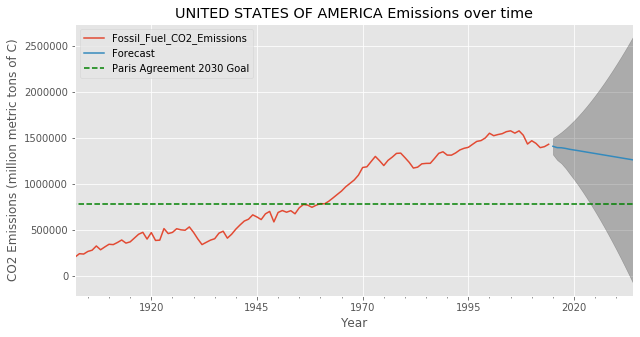

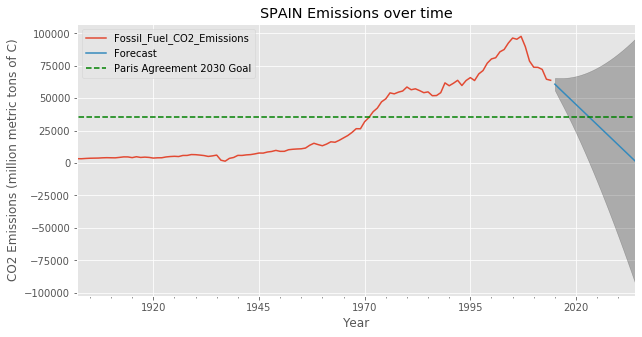

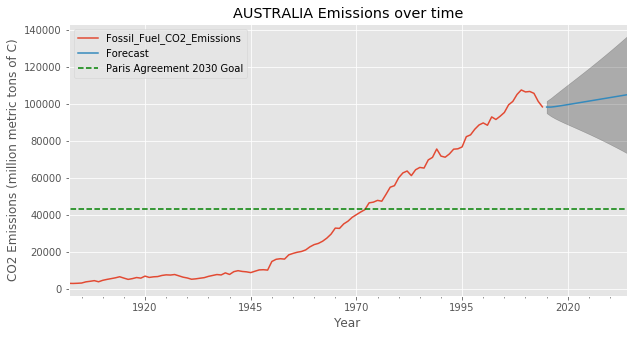

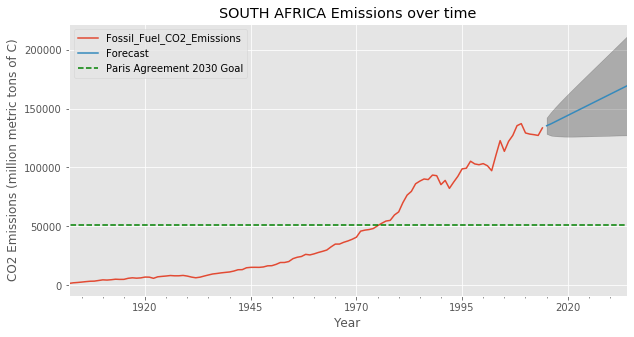

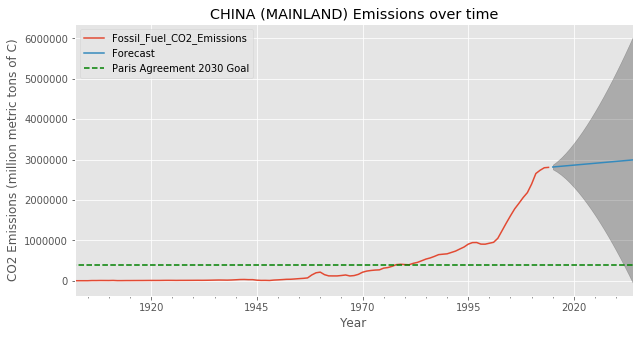

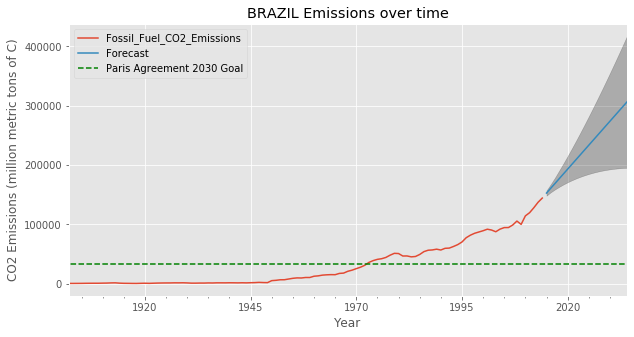

In [148]:
# Emissions forecasts with Paris Agreement Goals
for key in results_dict.keys():
    results = results_dict[key]
    prediction = results.get_forecast(steps=20)
    pred_conf = prediction.conf_int()
    
    ax = country_df_dict[key].plot(label='observed', figsize=(10,5))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.axhline(y = paris_levels[key], xmin = pd.to_datetime(1902, format = '%Y'),
               xmax = pd.to_datetime(2034, format = '%Y'), linestyle = '--', color = 'g', label = 'Paris Agreement 2030 Goal')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2 Emissions (million metric tons of C)')
    plt.title(f'{key[:-3]} Emissions over time')
    plt.legend(loc = 'upper left')
    plt.show()